In [1]:
from Utils import PlotUtlis, create_folder, mm2inch, set_mpl_defaults, convert_to_env_list_detail, reorder_df_attention, get_significance_stars

import pandas as pd
import copy
from matplotlib import font_manager as fm
import h5py
from matplotlib.colors import ListedColormap
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.patches as mpatches
from scipy.stats import spearmanr

set_mpl_defaults()

In [2]:
run_id = 'e52c8ac9a3e24c75ac871f63bbdea060'
exp_id = '115656750127464383'

In [3]:
PU = PlotUtlis(run_id = run_id, exp_id = exp_id)

In [4]:
create_folder(PU.plot_path_attention)

### Calculate attention score of each species 

In [5]:
df_attention = PU.create_attention_df()
# df_attention.to_csv(PU.df_attention_path)

# 排序各個環境因子的權重

In [6]:
df_attention = pd.read_csv(PU.df_attention_path, index_col = 0)
df_attention_sumsort = df_attention.sum().sort_values()
df_attention_sumsort.index = convert_to_env_list_detail(df_attention_sumsort.index)
df_attention_sumsort

Relative humidity       6.039870
Shortwave radiation     6.096121
EVI                     6.115756
LandcoverPC5            6.177886
Temperature             6.784828
Wind speed              7.113376
Precipitation           7.575675
LandcoverPC3            9.718896
LandcoverPC4            9.806830
LandcoverPC2           10.271141
Cloud area fraction    24.341763
LandcoverPC1           24.957857
dtype: float64

# BAR PLOT

In [7]:
df_attention_order = reorder_df_attention(df_attention)

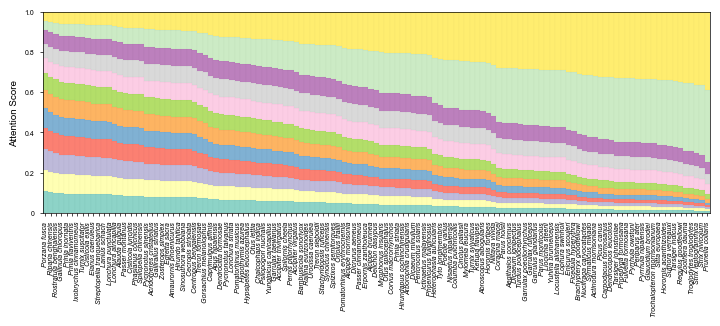

In [8]:
custom_colors = [
    "#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#80b1d3", 
    "#fdb462", "#b3de69", "#fccde5", "#d9d9d9", "#bc80bd", 
    "#ccebc5", "#ffed6f"
]

custom_cmap = ListedColormap(custom_colors)

fig, ax = plt.subplots(figsize = mm2inch(180, 80), constrained_layout = True)

df_attention_order.plot(kind="bar", stacked=True, colormap=custom_cmap, width=1, 
                      ax=ax, edgecolor="black", linewidth=0.01, legend = None)  # 設定細黑框

ax.set_ylabel("Attention Score")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(labels = [0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks(np.arange(len(df_attention_order.index)))
ax.set_xticklabels(df_attention_order.index, rotation=90, ha='center', va='top', fontstyle='italic')
ax.set_ylim(0, 1)
plt.margins(x=0)
ax.set_xlim(-0.5, len(df_attention_order.index) - 0.5)

plot_output = os.path.join(PU.plot_path_attention, 'attention_barplot.pdf')
# plt.savefig(plot_output, dpi = 500, transparent = True)
plt.show()

### Forest habitat

In [9]:
habitat = PU.get_species_habitat(df_attention_order)

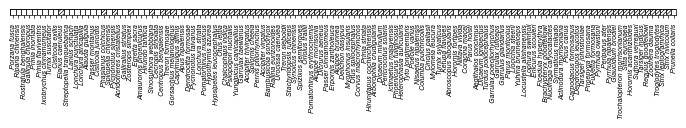

In [10]:
forest_hatch = '/////////'
non_forest_hatch = ''
fig, ax = plt.subplots(figsize = mm2inch(180, 30), gridspec_kw = {'left': 0.05, 'right': 0.99, 'bottom': 0.93, 'top': 0.98})

for i, h in enumerate(habitat):
    if h == 'Habitat_Forest':
        rect = mpatches.Rectangle(
            (i, 0), 1, 1,      
            facecolor='white', 
            edgecolor='black', 
            hatch=forest_hatch,
            linewidth = 0.5
        )
    else:
        rect = mpatches.Rectangle(
            (i, 0), 1, 1,
            facecolor='white',
            edgecolor='black',
            hatch=non_forest_hatch,
            linewidth = 0.5
        )
    ax.add_patch(rect)

ax.set_xlim(0, len(habitat))
ax.set_ylim(0, 1)
ax.set_xticks(range(len(habitat)))
ax.set_xticks(np.arange(len(df_attention_order.index))+0.5)
ax.set_xticklabels(df_attention_order.index, rotation=90, ha='center', va='top', fontstyle='italic')
ax.set_yticks([])

plot_output = os.path.join(PU.plot_path_attention, 'forest.pdf')
# plt.savefig(plot_output, dpi = 500, transparent = True)
plt.show()

### attention score by environmental factors

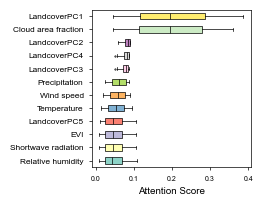

In [11]:
fig, ax = plt.subplots(figsize = mm2inch(65, 50), gridspec_kw = {'left': 0.33, 'right': 0.95, 'bottom': 0.15, 'top': 0.95})
box = ax.boxplot(df_attention_order.values, vert = False, patch_artist = True, labels = df_attention_order.columns,
                 medianprops = dict(color = 'black'),
                )

for patch, color in zip(box['boxes'], custom_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

ax.set_xlabel("Attention Score")
ax.set_yticklabels(list(df_attention_order.columns), fontsize = 6)

plot_output = os.path.join(PU.plot_path_attention, 'attention_boxplot_by_env.pdf')
# plt.savefig(plot_output, dpi = 500, transparent = True)
plt.show()

### clt vs avg.elev

In [12]:
avg_elevation = pd.read_csv(PU.avg_elev_path)

0.926943164362519 3.3347606852082876e-54


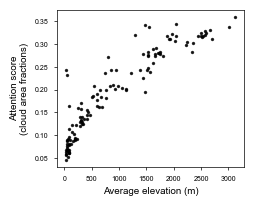

In [13]:
fig, ax = plt.subplots(figsize=mm2inch(65, 50), gridspec_kw = {'left': 0.22, 'right': 0.95, 'bottom': 0.15, 'top': 0.95})
ax.scatter(x = [avg_elevation.AverageElevation[avg_elevation.Species == sp.replace(' ', '_')].tolist()[0] for sp in df_attention_order.index],
           y = df_attention_order['Cloud area fraction'], 
           c = 'black', 
           alpha = 0.8, 
           s = 2)
ax.set_xlabel('Average elevation (m)')
ax.set_ylabel('Attention score\n(cloud area fractions)')
rho_cltelev, p_cltelev = spearmanr([avg_elevation.AverageElevation[avg_elevation.Species == sp.replace(' ', '_')].tolist()[0] for sp in df_attention_order.index], 
                                   df_attention_order['Cloud area fraction'])
print(rho_cltelev, p_cltelev)

plot_output = os.path.join(PU.plot_path_attention, 'attclt_elev.pdf')
# plt.savefig(plot_output, dpi = 500, transparent = True)
plt.show()

### forest non-forest boxplot

In [14]:
forest_values = df_attention_order['LandcoverPC1'][np.array(habitat) == 'Habitat_Forest']
non_forest_values = df_attention_order['LandcoverPC1'][np.array(habitat) != 'Habitat_Forest']
t_stat, p_value = ttest_ind(forest_values, non_forest_values)
significance_star = get_significance_stars(p_value)

print(t_stat, p_value)

5.466051743931204 2.45076672590869e-07


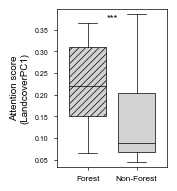

In [15]:
def set_box_color(bp, hatch=None):
    for patch in bp['boxes']:
        patch.set_edgecolor('black')
        patch.set_facecolor('lightgrey')
        if hatch:
            patch.set_hatch(hatch)
    for whisker in bp['whiskers']:
        whisker.set_color('black')
    for cap in bp['caps']:
        cap.set_color('black')
    for median in bp['medians']:
        median.set_color('black')

positions_forest = [-0.4]
positions_non_forest = [0.4]

fig, ax = plt.subplots(figsize = mm2inch(40, 50), gridspec_kw = {'left': 0.25, 'right': 0.95, 'bottom': 0.15, 'top': 0.95})

bp_forest = ax.boxplot([forest_values], positions = positions_forest, sym = '.', widths = 0.6, patch_artist = True)
bp_non_forest = ax.boxplot([non_forest_values], positions = positions_non_forest, sym = '.', widths = 0.6, patch_artist = True)

set_box_color(bp_forest, hatch='/////')  
set_box_color(bp_non_forest)

x_pos = 0
y_max = max(np.max(forest_values), np.max(non_forest_values))
ax.text(x_pos, y_max - 0.02, significance_star, ha = 'center', va = 'bottom', fontsize = 7, color = 'black')

ax.set_xticks([-0.4, 0.4])
ax.set_xticklabels(['Forest', 'Non-Forest'], fontsize = 6)
ax.set_ylabel("Attention score\n(LandcoverPC1)")
ax.set_ylim(min(forest_values.min(), non_forest_values.min()) - 0.01, 
            max(forest_values.max(), non_forest_values.max()) + 0.01)

plot_output = os.path.join(PU.plot_path_attention, 'forest_nonforest.pdf')
# plt.savefig(plot_output, dpi=500, transparent=True)
plt.show()